In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Flags

In [2]:
VALIDATE_NN = False
TRAIN = True
VALIDATE_SVM = True

In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter('ignore', category=ConvergenceWarning)

## Data

Consider a high-dimensional dataset, with 100 features, say, normally distributed with covariance $I_{100}$. We take a linear combination of the data (suppose it is simply a sum of the different features), and compute a non-linear function of it, say, cosine.

We wish to determine whether a neural network performs better at fitting the data compared to an SVM.

Later, on observing the performance on this dataset, we also consider data from a normal distribution but with a non-trivial covariance, which is dependent on w (100 * $1_{100}$), say, $I + w.w^T$.

In [4]:
DATA_SIZE = 10000
NUM_FEATURES = 25
CYCLES = 3

In [5]:
from torch.distributions import MultivariateNormal
from sklearn.model_selection import train_test_split

### Uncorrelated

In [6]:
uncorrelated_distribution = MultivariateNormal(torch.zeros(NUM_FEATURES), torch.eye(NUM_FEATURES))

In [7]:
torch.manual_seed(844)

X_uncorrelated = uncorrelated_distribution.sample((DATA_SIZE,))
X_uncorrelated.shape

torch.Size([10000, 25])

In [8]:
X_uncorrelated_row_norms = torch.sqrt(torch.sum(X_uncorrelated**2, dim=1)).reshape(-1, 1)

In [9]:
X_uncorrelated_scaled = X_uncorrelated / X_uncorrelated_row_norms

In [10]:
scale_factor = CYCLES * torch.pi / X_uncorrelated_scaled.sum(dim=1).max()
scale_factor

tensor(2.6826)

In [11]:
torch.manual_seed(974)

Y_uncorrelated = torch.sin(scale_factor * X_uncorrelated_scaled.sum(dim=1)).reshape(-1, 1) 
# + torch.randn(len(X_uncorrelated), 1) * 0.05
Y_uncorrelated.shape

torch.Size([10000, 1])

Text(0, 0.5, 'Y')

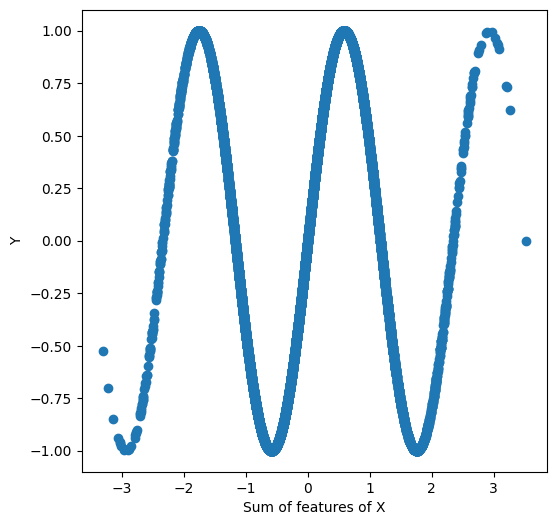

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(X_uncorrelated_scaled.sum(dim=1), Y_uncorrelated)
plt.xlabel('Sum of features of X')
plt.ylabel('Y')

In [13]:
X_training, X_test, Y_training, Y_test = train_test_split(X_uncorrelated_scaled, Y_uncorrelated, test_size=1000, random_state=13)
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=1000, random_state=9173)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([8000, 25]),
 torch.Size([8000, 1]),
 torch.Size([1000, 25]),
 torch.Size([1000, 1]),
 torch.Size([1000, 25]),
 torch.Size([1000, 1]))

In [14]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

## Models

### Neural network

In [15]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self, width, activation) -> None:
        super().__init__()
        self.width = width
        self.activation = activation
        self.input = nn.Sequential(
            nn.Linear(in_features=NUM_FEATURES, out_features=NUM_FEATURES),
            activation()
        )
        self.hidden = nn.Sequential(
            nn.Linear(in_features=NUM_FEATURES, out_features=width),
            activation()
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=width, out_features=1)
        )

    def forward(self, x):
        return self.output(self.hidden(self.input(x)))
    
    def clone(self):
        new_model = SimpleNN(self.width, self.activation)
        new_model.load_state_dict(self.state_dict())
        return new_model

In [16]:
device = 'cpu'

In [17]:
def get_cosine_angles(model: SimpleNN, ref_vector: torch.Tensor = torch.ones(NUM_FEATURES)):
    weights = next(model.input.parameters()).detach()
    return torch.tensor([torch.dot(weight, ref_vector) / (torch.linalg.norm(ref_vector) * torch.linalg.norm(weight)) for weight in weights])

In [18]:
depths = [0]
widths = [128, 256, 512, 1024, 2048, 4096]
activations = ['relu', 'tanh']
etas = [1e-4, 1e-3, 1e-2, 1e-1, 1.]
weight_decays = np.logspace(-4, 2, 7).tolist() + [0.0]
optimizers = ['adadelta']

In [19]:
import json

if VALIDATE_NN:
    best_score = -torch.inf
    best_depth = None
    best_width = None
    best_activation = None
    best_eta = None
    best_weight_decay = None
    best_optimizer = None
else:
    with open('configs/nn/hidden-function.json', 'r') as f:
        best_config = json.load(f)
    best_depth = best_config['depth']
    best_width = best_config['width']
    best_activation = best_config['activation']
    best_eta = best_config['eta']
    best_weight_decay = best_config['weight_decay']
    best_optimizer = best_config['optimizer']
    best_score = best_config['score']

In [20]:
from scripts.train import train_model
# from scripts.models import SimpleNN
from scripts.metrics import NegMeanSquaredError

total_count = len(depths) * len(widths) * len(activations) * len(etas) * len(weight_decays) * len(optimizers)
curr_count = 0
EPOCHS = 50

if VALIDATE_NN:
    print(f'Cross validating across {total_count} models.\n')

    for depth in depths:
        for width in widths:
            for activation in activations:
                for eta in etas:
                    for weight_decay in weight_decays:
                        for optimizer in optimizers:
                            curr_count += 1
                            torch.random.manual_seed(47647)
                            activation_fn = torch.nn.ReLU if activation == 'relu' else torch.nn.Tanh
                            optimizer_class = torch.optim.Adadelta if optimizer == 'adadelta' else torch.optim.Adam
                            model = SimpleNN(width, activation_fn).to(device)
                            history = train_model(
                                model=model,
                                train_dataloader=train_dataloader,
                                val_dataloader=val_dataloader,
                                loss_fn=torch.nn.L1Loss(),
                                optimizer=optimizer_class(params=model.parameters(), lr=eta, weight_decay=weight_decay),
                                metric=NegMeanSquaredError(),
                                epochs=EPOCHS,
                                verbose=0,
                                device=device
                            )
                            curr_score = history['val_score'][-1]
                            if curr_score > best_score:
                                best_score = curr_score
                                best_depth = depth
                                best_width = width
                                best_activation = activation
                                best_eta = eta
                                best_weight_decay = weight_decay
                                best_optimizer = optimizer
                            print(f'[{curr_count}/{total_count}]\tDepth:{depth}, Width:{width}, Actn.:{activation}, lr:{eta}, w_d:{weight_decay}, optimizer:{optimizer} => Score:{curr_score:.6f}')
    best_config = {
        'score': float(best_score),
        'depth': best_depth,
        'width': best_width,
        'activation': best_activation,
        'eta': best_eta,
        'weight_decay': best_weight_decay,
        'optimizer': best_optimizer
    }
    with open('configs/nn/hidden-function.json', 'w') as f:
        json.dump(best_config, f)

print(f'\nBest validation score after {EPOCHS} epochs: {best_score:.6f}. Best configuration:')
print(f'Depth:{best_depth}, Width:{best_width}, Actn.:{best_activation}, lr:{best_eta}, w_d:{best_weight_decay}, optimizer:{best_optimizer}')


Best validation score after 50 epochs: -0.002237. Best configuration:
Depth:0, Width:2048, Actn.:relu, lr:1.0, w_d:0.0, optimizer:adadelta


In [21]:
# from scripts.models import SimpleNN

torch.random.manual_seed(47647)
best_activation_fn = torch.nn.ReLU if best_activation == 'relu' else torch.nn.Tanh
best_model_nn = SimpleNN(best_width, best_activation_fn).to(device)

In [22]:
from scripts.metrics import NegMeanSquaredError
from scripts.utils import EarlyStopping

loss_fn = torch.nn.L1Loss()
best_optimizer_class = torch.optim.Adadelta if best_optimizer == 'adadelta' else torch.optim.Adam
optimizer = best_optimizer_class(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = NegMeanSquaredError()
early_stop = EarlyStopping(patience=50, min_delta=1e-4)

In [23]:
from scripts.train import train_model

if TRAIN:
    history = train_model(
        model=best_model_nn,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric=metric,
        epochs=500,
        early_stopping=early_stop,
        device=device,
        return_models=True
    )
    torch.save(best_model_nn.state_dict(), 'models/hidden-function.pth')
else:
    best_model_nn.load_state_dict(torch.load('models/hidden-function.pth'))

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.645090, Train score: -0.533404, Val loss: 0.641865, Val score: -0.577881
Epoch: 2 => Train loss: 0.381640, Train score: -0.285349, Val loss: 0.241346, Val score: -0.152134
Epoch: 3 => Train loss: 0.202935, Train score: -0.114699, Val loss: 0.138103, Val score: -0.054362
Epoch: 4 => Train loss: 0.154033, Train score: -0.053425, Val loss: 0.147071, Val score: -0.031395
Epoch: 5 => Train loss: 0.119002, Train score: -0.027692, Val loss: 0.127769, Val score: -0.031698
Epoch: 6 => Train loss: 0.104464, Train score: -0.021005, Val loss: 0.079884, Val score: -0.012543
Epoch: 7 => Train loss: 0.097218, Train score: -0.019344, Val loss: 0.108886, Val score: -0.024224
Epoch: 8 => Train loss: 0.091507, Train score: -0.017551, Val loss: 0.073189, Val score: -0.012856
Epoch: 9 => Train loss: 0.084672, Train score: -0.014876, Val loss: 0.055291, Val score: -0.008475
Epoch: 10 => Train loss: 0.077562, Train score: -0.012

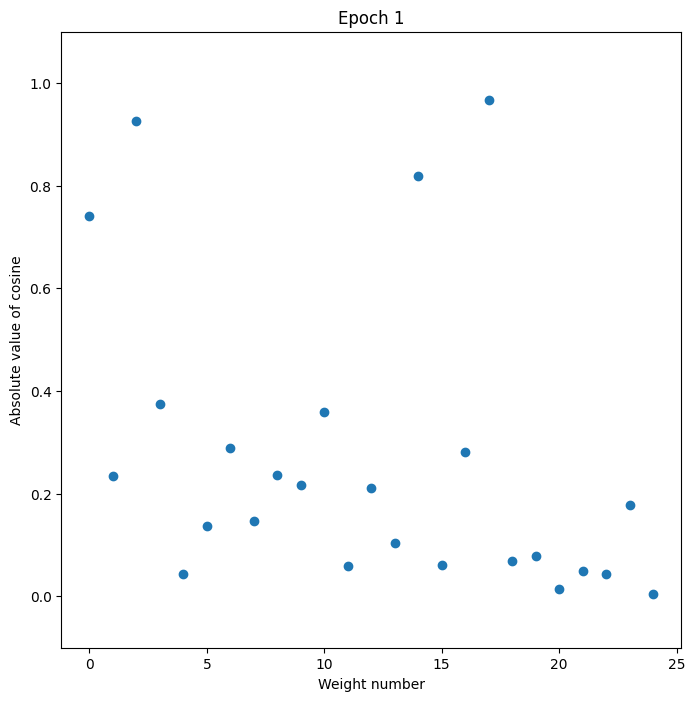

In [26]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
FPS = 3

def plot_cosines(i):
    cosines = get_cosine_angles(history['models'][i])
    ax.clear()

    ax.scatter(range(len(cosines)), cosines.abs())
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel('Absolute value of cosine')
    ax.set_xlabel('Weight number')
    ax.set_title(f'Epoch {i+1}')

ani = FuncAnimation(fig, plot_cosines, frames = 50, interval=1000/FPS, repeat=True)
writer = FFMpegWriter(fps=FPS, bitrate=1800, metadata=dict(arist='Me'))

ani.save('animations/cosine_variation.mp4', writer=writer)

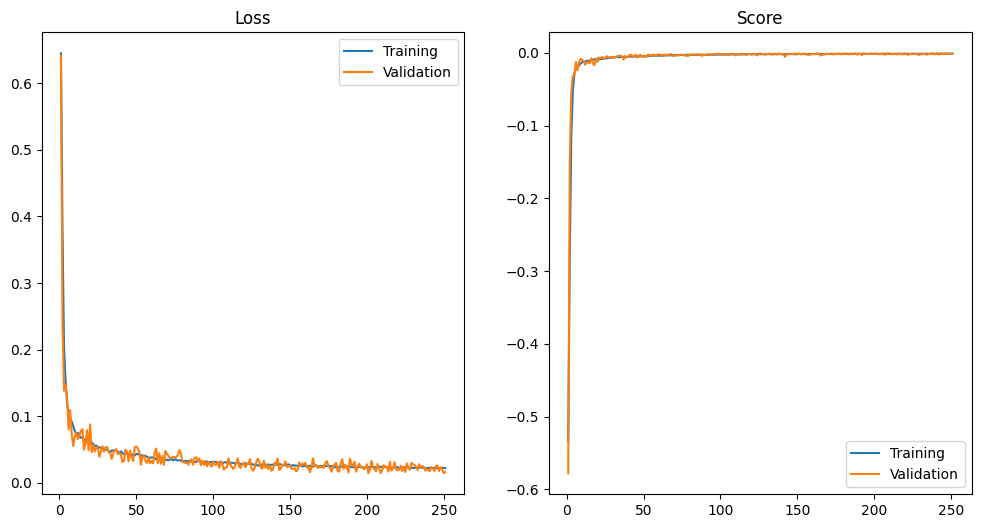

In [27]:
from scripts.utils import plot_train_history

if TRAIN:
    plot_train_history(history)

In [28]:
from scripts.test import predict

preds_train_nn, preds_val_nn = predict(best_model_nn, X_train, device), predict(best_model_nn, X_val, device)
preds_train_nn.shape, preds_val_nn.shape

(torch.Size([8000, 1]), torch.Size([1000, 1]))

In [29]:
score_train, score_val = metric(preds_train_nn, Y_train), metric(preds_val_nn, Y_val)
score_train, score_val

(tensor(-0.0007), tensor(-0.0009))

Text(0.5, 0.98, 'NN')

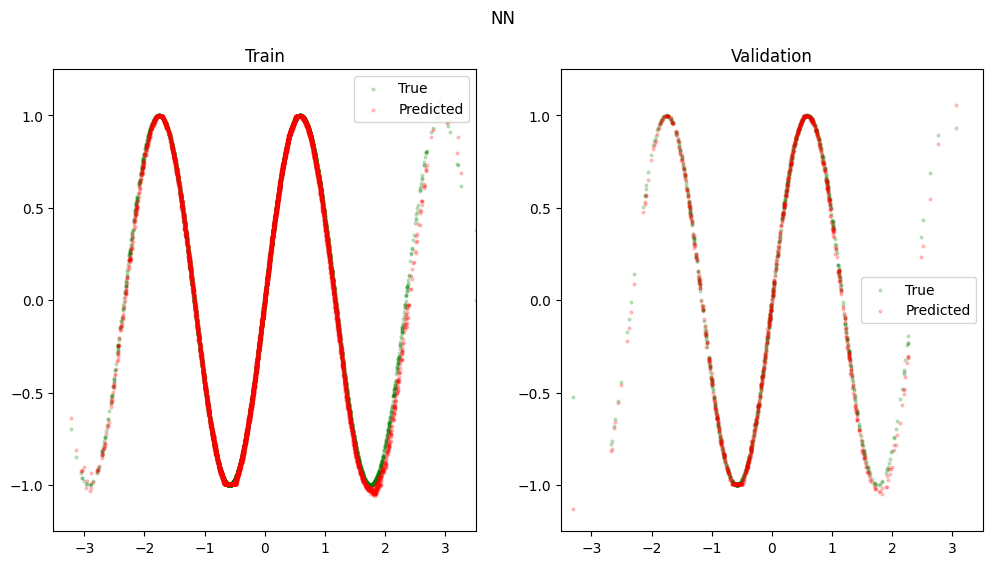

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_train.sum(dim=1), preds_train_nn, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Train')
plt.xlim(-CYCLES*torch.pi/scale_factor, CYCLES*torch.pi/scale_factor)
plt.ylim(-1.25, 1.25)
plt.legend()

plt.subplot(122)
plt.scatter(X_val.sum(dim=1), Y_val, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_val.sum(dim=1), preds_val_nn, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Validation')
plt.xlim(-CYCLES*torch.pi/scale_factor, CYCLES*torch.pi/scale_factor)
plt.ylim(-1.25, 1.25)
plt.legend()

plt.suptitle('NN')

### SVM

In [31]:
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import mean_squared_error, make_scorer
from scripts.ntk import get_ntk_feature_matrix
from sklearn.model_selection import GridSearchCV

In [32]:
X_train_ntk = get_ntk_feature_matrix(X_train, best_model_nn)
X_val_ntk = get_ntk_feature_matrix(X_val, best_model_nn)

In [33]:
(X_train_ntk.abs() <= 1e-8).sum(), (X_train_ntk.abs() > 1e-8).sum()

(tensor(446343575), tensor(1232425))

In [34]:
X_train_ntk

tensor([[-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.2957, -0.2566, -0.1946,  ...,  0.0000,  0.0000,  1.0000]])

In [35]:
model_base_ntk = LinearSVR()
params_ntk = {
    'C': np.logspace(-4, 4, 9)
}

gammas = np.logspace(-4, 4, 9).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVR(kernel='rbf', max_iter=int(1e4))
params_rbf = {
    'C': np.logspace(-4, 4, 9),
    'gamma': gammas
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [36]:
if VALIDATE_SVM: 
    model_cv_ntk = GridSearchCV(
        estimator=model_base_ntk,
        param_grid=params_ntk,
        scoring=scorer,
        n_jobs=1,
        cv=4,
        refit=False,
        verbose=3
    )
    model_cv_ntk.fit(X_train_ntk, Y_train.squeeze())
    best_params_ntk = model_cv_ntk.best_params_
    best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
    best_params_ntk, best_score_ntk

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END .........................C=0.0001;, score=-0.341 total time=   1.8s
[CV 2/4] END .........................C=0.0001;, score=-0.330 total time=   1.7s
[CV 3/4] END .........................C=0.0001;, score=-0.325 total time=   1.8s
[CV 4/4] END .........................C=0.0001;, score=-0.322 total time=   1.8s
[CV 1/4] END ..........................C=0.001;, score=-0.034 total time=   2.0s
[CV 2/4] END ..........................C=0.001;, score=-0.029 total time=   1.7s
[CV 3/4] END ..........................C=0.001;, score=-0.033 total time=   1.8s
[CV 4/4] END ..........................C=0.001;, score=-0.047 total time=   1.7s
[CV 1/4] END ...........................C=0.01;, score=-0.003 total time=   2.1s
[CV 2/4] END ...........................C=0.01;, score=-0.003 total time=   2.3s
[CV 3/4] END ...........................C=0.01;, score=-0.001 total time=   2.0s
[CV 4/4] END ...........................C=0.01;, 

In [37]:
if VALIDATE_SVM:
    model_cv_rbf = GridSearchCV(
        estimator=model_base_rbf,
        param_grid=params_rbf,
        scoring=scorer,
        n_jobs=1,
        cv=4,
        refit=False,
        verbose=3
    )
    model_cv_rbf.fit(X_train, Y_train.squeeze())
    best_params_rbf = model_cv_rbf.best_params_
    best_score_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])
    best_params_rbf, best_score_rbf

Fitting 4 folds for each of 99 candidates, totalling 396 fits
[CV 1/4] END ...........C=0.0001, gamma=0.0001;, score=-0.520 total time=   2.0s
[CV 2/4] END ...........C=0.0001, gamma=0.0001;, score=-0.497 total time=   1.8s
[CV 3/4] END ...........C=0.0001, gamma=0.0001;, score=-0.497 total time=   2.0s
[CV 4/4] END ...........C=0.0001, gamma=0.0001;, score=-0.488 total time=   1.9s
[CV 1/4] END ............C=0.0001, gamma=0.001;, score=-0.520 total time=   1.8s
[CV 2/4] END ............C=0.0001, gamma=0.001;, score=-0.497 total time=   1.7s
[CV 3/4] END ............C=0.0001, gamma=0.001;, score=-0.497 total time=   1.8s
[CV 4/4] END ............C=0.0001, gamma=0.001;, score=-0.488 total time=   1.8s
[CV 1/4] END .............C=0.0001, gamma=0.01;, score=-0.520 total time=   1.7s
[CV 2/4] END .............C=0.0001, gamma=0.01;, score=-0.497 total time=   1.8s
[CV 3/4] END .............C=0.0001, gamma=0.01;, score=-0.497 total time=   1.8s
[CV 4/4] END .............C=0.0001, gamma=0.01;

In [38]:
import json

if VALIDATE_SVM:
    if best_score_rbf >= best_score_ntk:
        best_model_km = SVR(C=best_params_rbf['C'], kernel='rbf', gamma=best_params_rbf['gamma'])
        best_config = {
            'kernel': 'rbf',
            'C': best_params_rbf['C'],
            'gamma': best_params_rbf['gamma']
        }
        with open('configs/svm/hidden-function.json', 'w') as f:
            json.dump(best_config, f)
    else:
        best_model_km = LinearSVR(C=best_params_ntk['C'])
        best_config = {
            'kernel': 'ntk',
            'C': best_params_ntk['C']
        }
        with open('configs/svm/hidden-function.json', 'w') as f:
            json.dump(best_config, f)
else:
    with open('configs/svm/hidden-function.json', 'r') as f:
        best_config = json.load(f)
    if best_config['kernel'] == 'rbf':
        best_model_km = SVR(C=best_config['C'], gamma=best_config['gamma'])
    else:
        best_model_km = LinearSVR(C=best_config['C'])
kernel_to_use = best_config['kernel']

In [39]:
if kernel_to_use == 'rbf':
    best_model_km.fit(X_train, Y_train.squeeze())
else:
    best_model_km.fit(X_train_ntk, Y_train.squeeze())

In [42]:
if kernel_to_use == 'rbf':
    preds_train_km, preds_val_km = best_model_km.predict(X_train), best_model_km.predict(X_val)
else:
    preds_train_km, preds_val_km = best_model_km.predict(X_train_ntk), best_model_km.predict(X_val_ntk)
score_train, score_val = mean_squared_error(Y_train, preds_train_km), mean_squared_error(Y_val, preds_val_km)
score_train, score_val

(3.524487079215903e-05, 0.0004003750774368815)

Text(0.5, 0.98, 'SVM')

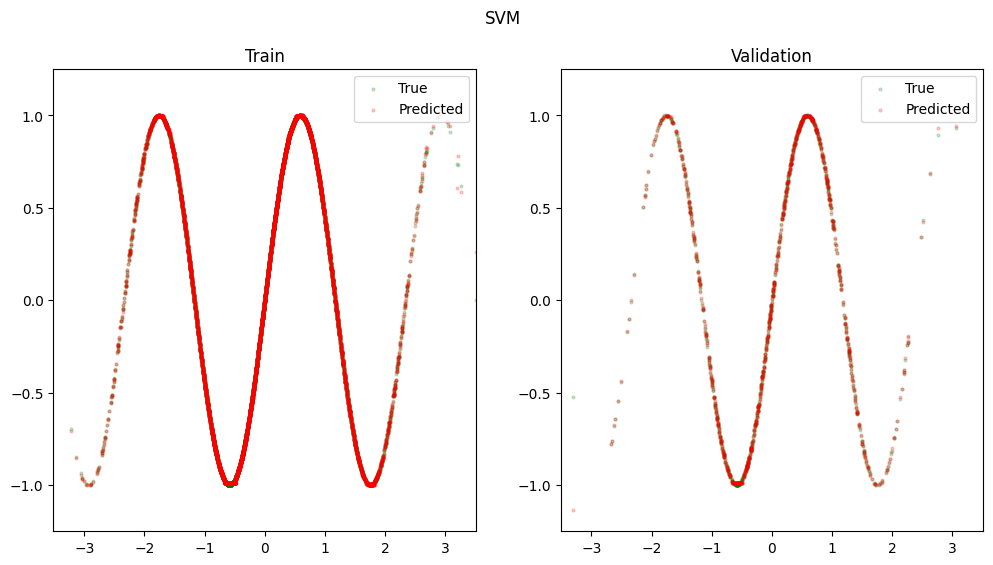

In [44]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_train.sum(dim=1), preds_train_km, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Train')
plt.xlim(-CYCLES*torch.pi/scale_factor, CYCLES*torch.pi/scale_factor)
plt.ylim(-1.25, 1.25)
plt.legend()

plt.subplot(122)
plt.scatter(X_val.sum(dim=1), Y_val, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_val.sum(dim=1), preds_val_km, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Validation')
plt.xlim(-CYCLES*torch.pi/scale_factor, CYCLES*torch.pi/scale_factor)
plt.ylim(-1.25, 1.25)
plt.legend()

plt.suptitle('SVM')